In [17]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from PIL import Image

from PIL import ImageFont
from PIL import ImageDraw 

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

import copy
import pdb

In [18]:
with open("./tokenizer.pkl","rb") as handle:
    tokenizer = pickle.load(handle)
handle.close()

In [19]:

# see if loaded properly - should be 30212
1 + len(tokenizer.word_index)

6454

In [20]:
reverse_tokenizer = {index: word for word,index in tokenizer.word_index.items()}

In [48]:
with open("./data/features/train_features.pkl", "rb") as handle:
    valid_features = pickle.load(handle)
handle.close()

In [22]:

valid_ids = []
for k in valid_features:
    valid_ids.append(k)

In [23]:
def get_photo_features(photo_id):
    return valid_features[photo_id]


In [24]:
model1 = load_model("./fresh_models/model_0.h5")

In [25]:
model1.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 155)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 155, 300)     1936200     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [26]:
def generate_predictions_id(photo_id, model, tokenizer, reverse_tokenizer, max_length = 155):
    photo_features = get_photo_features(photo_id)
    # build up an array for the output sequence
    in_seq = np.repeat(0, max_length)
    in_seq[0] = tokenizer.word_index["startseq"]
    # keep track of the end token
    end_token = tokenizer.word_index["endseq"]
    for i in range(1, max_length):
        # get the prediction of the next word 
        pred = model.predict([photo_features,in_seq.reshape(1,-1)], verbose=0)
        # get just the index that is predicted
        pred = np.argmax(pred)
        in_seq[i] = pred
        # check if you've preached the end token
        if pred == end_token:
            break
    """
    Now, convert the list of integers corresponding to words to acutal words
    """
    # remove the `startseq` token at the front.
    out_seq = in_seq[1:]
    # build up the ouptut string
    out_string = []
    for idx in out_seq:
        if idx == 0 or idx == end_token:
            break
        out_string.append(reverse_tokenizer[idx])
    return(" ".join(out_string))

In [27]:
class SequenceCandidate(object):
    
    @staticmethod
    def template_seq(start_idx = 1, max_length = 155, ignore_idx = None, alpha = .9):
        seq = np.repeat(0,155)
        seq[0] = start_idx
        # also keep track of the probabilities you've seen
        probs = np.repeat(0.0,155)
        probs[0] = 1
        return SequenceCandidate(seq, probs, max_length, ignore_idx, alpha)
        
        
    
    def __init__(self, seq, probs, max_length = 155, ignore_idx = None, alpha = .9):
        assert len(seq) == max_length
        self._max_length = max_length
        self._seq = seq
        self._probs = probs
        # store the number of populated elements in sequence
        self._num_elem = max_length # temporarily assume sequence is fully populated. 
        for i in range(len(seq)):
            if seq[i] == 0:
                self._num_elem = i # update number of elements in the sequence. 
                break
        # keep track of which bigrams are in the sequence
        self._bigrams = set()
        self._ignore_idx = ignore_idx
        if ignore_idx is None:
            self._ignore_idx = []
        self._prob_weights = [alpha**i for i in range(max_length)]
    
    # returns a new candidate, with the new token added
    def add_token(self, token, prob):
        # see that there's room to add in the sequence
        if self._num_elem >= self._max_length:
            raise IndexError("Sequence is already populated.\nCan't add any more tokens to it.")
        # get a copy of the new candidate
        newcandidate = copy.deepcopy(self)
        # add the token to the sequence
        newcandidate._seq[self._num_elem] = token
        # update the probability sum
        newcandidate._probs[self._num_elem] = prob
        # add the newly added bigram to the list of bigrams
        newcandidate._bigrams.add(tuple(newcandidate._seq[self._num_elem - 1 : newcandidate._num_elem + 1]))
        # increment the number of stored elements
        newcandidate._num_elem += 1
        return(newcandidate)
    
    def probsum(self):
        # sum of the word probabilities, ignoring the indecies in `ignore_idx`.
        valid_probs = self._probs[~np.in1d(self._seq, self._ignore_idx)]
        # return a weighted sum
        return np.sum(np.multiply(valid_probs, self._prob_weights[:len(valid_probs)]))
    
    def final_token(self):
        return self._seq[self._num_elem - 1]
    
    # it is assumed that the first word is the start token <startseq>, so it is ignored. 
    def to_words(self,reverse_tokenizer, end_idx):
        # build up the words you want to output
        out_words = []
        for i in range(1,len(self._seq)):
            # current word index
            idx = self._seq[i]
            if idx == 0 or idx == end_idx:
                break
            if idx in self._ignore_idx:
                continue
            # don't add repeated words
            if self._seq[i - 1] != idx:
                out_words.append(reverse_tokenizer[idx])
        out_string = " ".join(out_words)
        return out_string
    
    # make the object sortabe **by the sum of the probability**
    def __lt__(self, other):
        try:
            return self.probsum() < other.probsum()
        except AttributeError: # don't know how to compare with general objects
            return NotImplemented

In [28]:
def generate_predictions_beam_id(photo_id, model,reverse_tokenizer, width, num_neighbors,
                                 top_n = 3, end_idx = 2, max_length = 155, ignore_idx = [4], alpha = .9):
    # isolate the photo features
    photo_features = get_photo_features(photo_id)
    # keep track of the accepted sequences
    accepted_sequences = []
    # keep track of the current population
    population = []
    # add a start sequence to the population
    start_sequence = SequenceCandidate.template_seq(ignore_idx = ignore_idx, alpha = alpha)
    population.append(start_sequence)
    for i in range(max_length - 1):
        tmp = []
        for cand_seq in population:
            # get the prediction of the next word 
            pred = model.predict([photo_features, cand_seq._seq.reshape(1,-1)], verbose=0)[0]
            # sort the predicted next words by their probabilities
            pred_argsort = pred.argsort()
            # add candidates for each of the <num_neighbors> neighbors
            for next_idx in pred_argsort[-num_neighbors:]:
                # if we're starting to repeat bigrams, accept the current candidate
                if (cand_seq.final_token(), next_idx) in cand_seq._bigrams:
                    accepted_sequences.append(cand_seq)
                    continue
                # add the predicted word to get a new candidate
                next_prob = pred[next_idx]
                new_candidate = cand_seq.add_token(next_idx,next_prob)
                # if the next suggested token is <endseq>, add to accepted_sequences
                if next_idx == end_idx:
                    accepted_sequences.append(new_candidate)
                else:
                    tmp.append(new_candidate)
        # prune the population to keep only the top <width> candidates. 
        try:
            population = sorted(tmp)[-width:]
        except:
            # fewer than <width> individuals remain - stop growing tree and keep curren partial sequences
            population = tmp
            break
    # add current population to accepted sequences
    accepted_sequences = sorted(accepted_sequences + population, reverse = True)
    # build output string
    accepted = 0
    outputwords, outputprobs = [], []
    for acc_seq in accepted_sequences:
        seq_string = acc_seq.to_words(reverse_tokenizer,end_idx)
        if seq_string not in outputwords:
            outputwords.append(seq_string)
            outputprobs.append(acc_seq.probsum())
            accepted += 1
            if accepted >= top_n:
                break
    output = list(zip(outputwords, outputprobs))
    return output

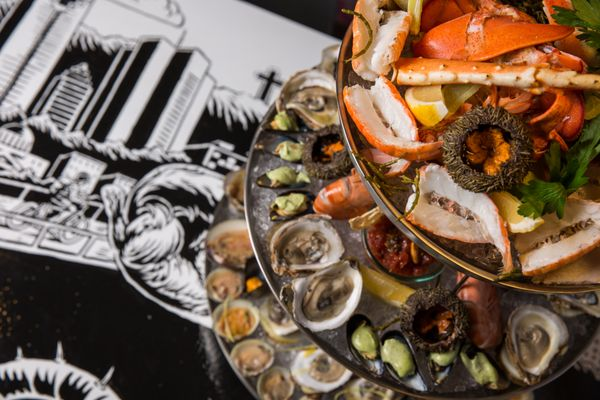

In [56]:
# im = Image.open("./data/yelp_photos/photos/__G6_HHI2_DZQTwv1HgwvA.jpg")
im = Image.open("./data/yelp_photos/photos/099cQBxcE5F6No0_bB7MrA.jpg")
im

In [58]:
generate_predictions_beam_id("099cQBxcE5F6No0_bB7MrA", model1, reverse_tokenizer, width = 10,
                             num_neighbors=6, top_n = 5, ignore_idx = [], alpha = .8)


[('salad', 1.4223591559901834),
 ('chicken salad', 1.39600579418242),
 ('salad and salad', 1.3380946682468056),
 ('salad with salad', 1.335362219144404),
 ('salad and chicken salad', 1.2733447092166543)]

In [32]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [33]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        
        # convert probability to integer
        yhat = np.argmax(yhat)
        
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [36]:
description = generate_desc(model1, tokenizer, valid_features["__G6_HHI2_DZQTwv1HgwvA"], 155)

In [37]:
description

'startseq mcdonalds buttermilk crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy crispy cri

In [49]:
valid_features

{'002gqWfVal1D2DT6oA-bVQ': array([[ 0.      ,  0.      ,  0.      , ...,  6.533517, 10.985849,
          0.      ]], dtype=float32),
 '002GtTSYyQ4swIZyEnfF5A': array([[0.535839, 0.      , 0.      , ..., 6.174811, 0.      , 0.      ]],
       dtype=float32),
 '004a5VhdS6w9PaH0QmlX9g': array([[ 0.       ,  0.       ,  0.       , ..., 13.606103 ,  5.1117635,
          0.       ]], dtype=float32),
 '005Pl2rEa-y9OfU8Nbcy4Q': array([[0.       , 0.       , 0.       , ..., 0.       , 3.4806058,
         0.       ]], dtype=float32),
 '007FeerwcQQRx7ck_xA0QA': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '00b_U2evhgjAdVf-Idxmeg': array([[ 0.      ,  0.      ,  0.      , ..., 34.158802,  0.      ,
          0.      ]], dtype=float32),
 '00fW0BpDCRGX9lJ0w_lkmg': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '00ief8P3q8t0_6mvnBE9dQ': array([[0.      , 0.      , 0.      , ..., 9.529887, 0.      , 0.      ]],
       dtype=float32),
 '00MKMHxB8CbSmOZUlLoJJg': array([[ 0.      ,  0